# Import Library

In [39]:
#Import Library
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import shutil

# Data Preprocessing

In [40]:
# read train data and test data from directory
# dir_dataset = "E:\ilmu\Kuliah\sem 7 dan 8\Tugas Akhir\dataset\CICIDS2017\Dataset CICIDS2017"
dir_dataset = 'TRAIN DATA AND TEST DATA DIRECTORY'

df_train = pd.read_csv(dir_dataset + '\\train.csv')
df_test = pd.read_csv(dir_dataset + '\\test.csv')

In [41]:
#  load dataset into train data, train labels, test data and test labels
def load_train_test(df_train, df_test):
    train_x, train_y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

In [42]:
# call function load_train_test()
train_x, train_y, test_x, test_y = load_train_test(df_train, df_test)

In [44]:
# scaling train data and test data
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [45]:
# Custom layer Densetranspose for NDAE
# NDAE doesn't have decoder 
# NDAE using current layer encoder as decoder 
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'dense': self.dense,
          'activation': self.activation
      })
      return config
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
    self.W = tf.transpose(self.dense.weights[0]) 
    super().build(batch_input_shape)
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.dense.input_shape[-1])
  def call(self, inputs):
    z = tf.matmul(inputs, self.W)
    return self.activation(z + self.biases)


In [46]:
# construct first autoencoder
num_hidden = (train_x.shape[1], 14, 28, 28)

Dense_11 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_12 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_13 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_1 = Input(shape=(num_hidden[0],))

#Encoder
encoded_11 = Dense_11(inputs_1)
encoded_12 = Dense_12(encoded_11)
encoded_13 = Dense_13(encoded_12)

#Decoder
decoded_11 = DenseTranspose(Dense_13, activation='sigmoid')(encoded_13)
decoded_12 = DenseTranspose(Dense_12, activation='sigmoid')(decoded_11)
outputs_1 = DenseTranspose(Dense_11, activation='sigmoid')(decoded_12)

AE_1=Model(inputs_1, outputs_1)
Encoder_1=Model(inputs_1, decoded_12)

In [47]:
# construct second autoencoder 
Dense_21 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_2 = Input(shape=(num_hidden[1],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)

#Decoder
decoded_21 = DenseTranspose(Dense_22, activation='sigmoid')(encoded_22)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_21)

AE_2=Model(inputs_2, outputs_2)
Encoder_2=Model(inputs_2, decoded_21)

In [48]:
#  construct random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [49]:
Encoder_1.summary()
Encoder_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_5 (Dense)             (None, 14)                1092      
                                                                 
 dense_6 (Dense)             (None, 28)                420       
                                                                 
 dense_7 (Dense)             (None, 28)                812       
                                                                 
 dense_transpose_5 (DenseTra  (None, 28)               840       
 nspose)                                                         
                                                                 
 dense_transpose_6 (DenseTra  (None, 14)               434       
 nspose)                                                   

In [50]:
# training first autoencoder
AE_1.compile(optimizer='rmsprop', loss= 'mse')
AE_1.fit(train_x,train_x,epochs=10,batch_size=128,shuffle=True)

Epoch 1/10
5303/5303 [==============================] - 16s 3ms/step - loss: 0.9333
Epoch 2/10
5303/5303 [==============================] - 17s 3ms/step - loss: 0.8962
Epoch 3/10
5303/5303 [==============================] - 17s 3ms/step - loss: 0.8960
Epoch 4/10
5303/5303 [==============================] - 16s 3ms/step - loss: 0.8960
Epoch 5/10
5303/5303 [==============================] - 15s 3ms/step - loss: 0.8960
Epoch 6/10
5303/5303 [==============================] - 18s 3ms/step - loss: 0.8959
Epoch 7/10
5303/5303 [==============================] - 13s 3ms/step - loss: 0.8959
Epoch 8/10
5303/5303 [==============================] - 11s 2ms/step - loss: 0.8959
Epoch 9/10
5303/5303 [==============================] - 11s 2ms/step - loss: 0.8959
Epoch 10/10
5303/5303 [==============================] - 11s 2ms/step - loss: 0.8959


In [51]:
# encode input data
AE_1_encoded_train = Encoder_1.predict(train_x)
AE_1_encoded_test = Encoder_1.predict(test_x)

5303/5303 [==============================] - 6s 1ms/step


In [52]:
# training second autoencoder with encoded data
AE_2.compile(optimizer='rmsprop', loss= 'mse')
AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=128,shuffle=True)

Epoch 1/10
5303/5303 [==============================] - 11s 2ms/step - loss: 0.0059
Epoch 2/10
5303/5303 [==============================] - 10s 2ms/step - loss: 0.0013
Epoch 3/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 4/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 5/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 6/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 7/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 8/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 9/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013
Epoch 10/10
5303/5303 [==============================] - 9s 2ms/step - loss: 0.0013


In [53]:
# encoded input data
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

5303/5303 [==============================] - 6s 1ms/step


In [54]:
# training random forest and evaluate accuracy
rfc.fit(AE_2_encoded_train, train_y)
rfc.score(AE_2_encoded_test, test_y)

0.8936058607540476

# Evaluation Metric
Evaluation metrics are used to assess the performance of a model. The metrics used include precision, recall, F1 score, accuracy, and ROC curve.

In [55]:
testResult = rfc.predict(AE_2_encoded_test)

In [56]:
print(classification_report(test_y, testResult))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    136200
           1       0.92      0.50      0.65     33471

    accuracy                           0.89    169671
   macro avg       0.91      0.75      0.79    169671
weighted avg       0.90      0.89      0.88    169671



In [57]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_y, y_pred=testResult)

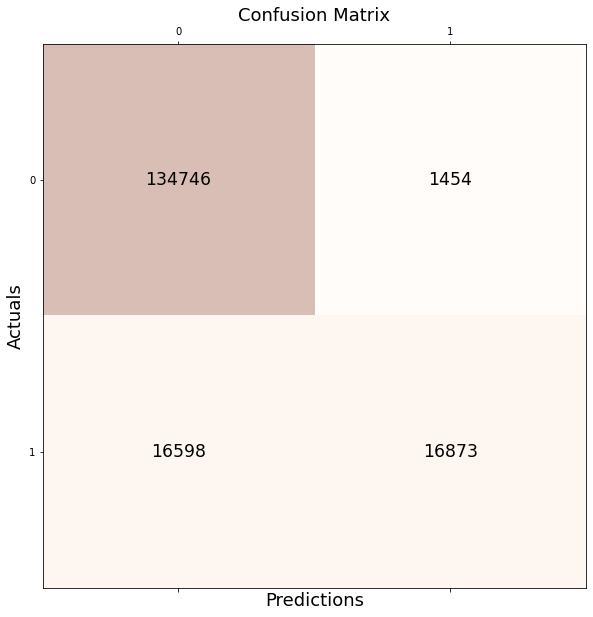

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

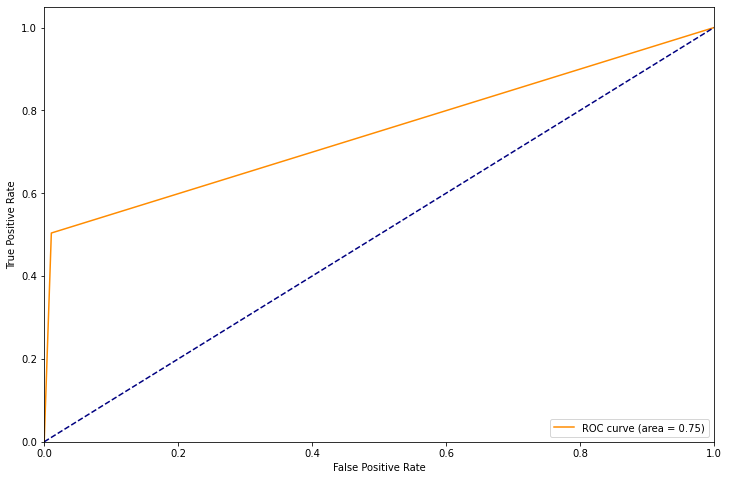

In [59]:
plt.figure(figsize = (12, 8))

fpr, tpr, _ = roc_curve(test_y, testResult)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# 1. Hyperparameter Testing
The hyperparameters varied in this experiment are the batch size and the choice of optimizer. This testing is conducted to find the most optimal hyperparameters based on the highest accuracy. The code used is the same as before

[Adam, RMSprop]

[16, 32, 64, 128, 256]

In [34]:
def hyperparameter_testing(batch_size, opt, results):
    print('==============================')
    print('batch_size =', batch_size)
    print('optimizer =', opt)
    AE_1.compile(optimizer=opt, loss= 'mse')
    AE_1.fit(train_x,train_x,epochs=10,batch_size=batch_size)

    AE_1_encoded_train = Encoder_1.predict(train_x)
    AE_1_encoded_test = Encoder_1.predict(test_x)

    AE_2.compile(optimizer=opt, loss= 'mse')
    AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=batch_size)

    AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
    AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)
    rfc.fit(AE_2_encoded_train, train_y)
    acc = rfc.score(AE_2_encoded_test, test_y)
    results.append([acc, opt, batch_size])
    print(rfc.score(AE_2_encoded_test, test_y))

    print()

    testResult = rfc.predict(AE_2_encoded_test)
    print(classification_report(test_y, testResult))

In [35]:
optlist = ['rmsprop', 'adam']
batch_size_list = [16, 32, 64, 128, 256]
results = []
for opt in optlist:
    for batch_size in batch_size_list: 
        hyperparameter_testing(batch_size, opt, results)

batch_size = 16
optimizer = rmsprop
Epoch 1/10
42418/42418 [==============================] - 76s 2ms/step - loss: 0.9017
Epoch 2/10
42418/42418 [==============================] - 68s 2ms/step - loss: 0.8960
Epoch 3/10
42418/42418 [==============================] - 67s 2ms/step - loss: 0.8960
Epoch 4/10
42418/42418 [==============================] - 67s 2ms/step - loss: 0.8960
Epoch 5/10
42418/42418 [==============================] - 69s 2ms/step - loss: 0.8960
Epoch 6/10
42418/42418 [==============================] - 67s 2ms/step - loss: 0.8960
Epoch 7/10
42418/42418 [==============================] - 67s 2ms/step - loss: 0.8960
Epoch 8/10
42418/42418 [==============================] - 68s 2ms/step - loss: 0.8960
Epoch 9/10
42418/42418 [==============================] - 68s 2ms/step - loss: 0.8960
Epoch 10/10
5303/5303 [==============================] - 6s 1ms/step
Epoch 1/10
42418/42418 [==============================] - 63s 1ms/step - loss: 0.0012
Epoch 2/10
42418/42418 [===========

5303/5303 [==============================] - 6s 1ms/step
Epoch 1/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2166e-04
Epoch 2/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2086e-04
Epoch 3/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2080e-04
Epoch 4/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2075e-04
Epoch 5/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2069e-04
Epoch 6/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2064e-04
Epoch 7/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2065e-04
Epoch 8/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2059e-04
Epoch 9/10
5303/5303 [==============================] - 9s 2ms/step - loss: 6.2057e-04
Epoch 10/10
5303/5303 [==============================] - 6s 1ms/step
0.9359171573221117

              precision    recall  f1-score   support

           0    

In [36]:
maxacc = 0
chosen_hyperparameter = None
for result in results:
    acc = result[0]
    if maxacc < acc:
        maxacc = acc
        chosen_hyperparameter = result.copy()

## Result of Hyperparameter Testing

In [ ]:
for r in results:
    print(f'accuracy: {r[0]} - optimizer: {r[1]} - batch size: {r[2]}')

# 2. Model Validation Testing
Testing is performed using K-Fold validation with the most optimal hyperparameters. The results of this testing include the precision, recall, accuracy, F1-score, ROC curve, and the training time for each iteration of the model.

In [37]:
def convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list ):
    print('==============================')
    print('optimizer =', opt)
    print('batch size =', batch_size)
    print('KFold = 10')
    kfold = KFold(n_splits=10, shuffle=True)
    AE_1.compile(optimizer=opt, loss= 'mse')
    AE_2.compile(optimizer=opt, loss= 'mse')
    total_time1 = 0
    total_time2 = 0
    total_acc = 0
    i = 1
    
    train_x, train_y, _, _ = load_train_test(df_train, df_test)
    for train_idx, valid_idx in kfold.split(train_x):
        print('\nCurrent KFold = ', i)
        Xtrain, Xvalid = train_x.iloc[train_idx], train_x.iloc[valid_idx]
        Ytrain, Yvalid = train_y.iloc[train_idx], train_y.iloc[valid_idx]
        #scaling
        scaler_kfold = StandardScaler()
        scaler_kfold.fit(Xtrain)
        Xtrain_scaled = scaler_kfold.transform(Xtrain)
        Xvalid_scaled = scaler_kfold.transform(Xvalid)
        # train AE1
        time_before_training_AE_1 = datetime.now()
        AE_1.fit(Xtrain_scaled, Xtrain_scaled, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_1 = datetime.now()
        delta_time_AE_1 = time_after_training_AE_1 - time_before_training_AE_1
        # encoder 1
        AE_1_encoded_train = Encoder_1.predict(Xtrain_scaled)
        AE_1_encoded_valid = Encoder_1.predict(Xvalid_scaled)

        # train AE2
        time_before_training_AE_2 = datetime.now()
        AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_2 = datetime.now()
        delta_time_AE_2 = time_after_training_AE_2 - time_before_training_AE_2
        
        # encoder 2
        AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
        AE_2_encoded_valid = Encoder_2.predict(AE_1_encoded_valid)
        
        #training RF
        rfc.fit(AE_2_encoded_train, Ytrain)
        
        print(time_before_training_AE_1)
        print(time_after_training_AE_1)
        print('time taken for training 1st autoencoder', delta_time_AE_1.total_seconds())
        print()
        print(time_before_training_AE_2)
        print(time_after_training_AE_2)
        print('time taken for training 2nd autoencoder', delta_time_AE_2.total_seconds())
        print()
        print('total time =', delta_time_AE_1.total_seconds() + delta_time_AE_2.total_seconds())
        
        total_time1 += delta_time_AE_1.total_seconds()
        total_time2 += delta_time_AE_2.total_seconds()
        time_list.append([delta_time_AE_1.total_seconds(), delta_time_AE_2.total_seconds()])
        
        print('Data Train')
        trainResult = rfc.predict(AE_2_encoded_train)
        print(rfc.score(AE_2_encoded_train, Ytrain))
        print(classification_report(Ytrain, trainResult))
        
        print('Data Valid')
        validResult = rfc.predict(AE_2_encoded_valid)
        valid_acc = rfc.score(AE_2_encoded_valid, Yvalid)
        total_acc += valid_acc
        acc_list.append(valid_acc)
        print(valid_acc)
        print(classification_report(Yvalid, validResult))
            
        print()
        
        fpr, tpr, _ = roc_curve(Yvalid, validResult)
        roc_auc = auc(fpr, tpr)
        roc_list.append([fpr, tpr, roc_auc])
        print()
        i+=1
        
    avg_time_AE_1 = total_time1 / 10 
    avg_time_AE_2 = total_time2 / 10
    avg_total_val_acc = total_acc / 10
    print('Average training time for AE_1:', avg_time_AE_1, 'seconds')
    print('Average training time for AE_2:', avg_time_AE_2, 'seconds')
    print('Average accuracy of 10 folds :', avg_total_val_acc)

In [38]:
epochs = 10
opt = chosen_hyperparameter[1]
batch_size = chosen_hyperparameter[2]
roc_list = []
time_list = []
acc_list = []
convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list)

optimizer = rmsprop
batch size = 128
KFold = 10

Current KFold =  1
Epoch 1/10
4772/4772 [==============================] - 12s 2ms/step - loss: 0.8960
Epoch 2/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 3/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 4/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 5/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 6/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 7/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 8/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 9/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 10/10
2121/2121 [==============================] - 2s 1ms/step
Epoch 1/10
4772/4772 [==============================] - 8s 2ms/step - loss: 6.1014e-04
Epoch 2/10
4772/4772

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     54569
           1       0.95      0.57      0.71     13299

    accuracy                           0.91     67868
   macro avg       0.93      0.78      0.83     67868
weighted avg       0.91      0.91      0.90     67868




Current KFold =  4
Epoch 1/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 2/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 3/10
4772/4772 [==============================] - 11s 2ms/step - loss: 0.8960
Epoch 4/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 5/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 6/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 7/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 8/10
4772/4772 [==============================] - 10s 2ms

0.9273345524735066
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    490489
           1       0.96      0.66      0.78    120324

    accuracy                           0.93    610813
   macro avg       0.94      0.83      0.87    610813
weighted avg       0.93      0.93      0.92    610813

Data Valid
0.913891672069311
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     54395
           1       0.92      0.62      0.74     13473

    accuracy                           0.91     67868
   macro avg       0.92      0.80      0.85     67868
weighted avg       0.91      0.91      0.91     67868




Current KFold =  7
Epoch 1/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 2/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 3/10
4772/4772 [==============================] - 10s 2ms/step - loss: 0.8960
Epoch 4/10
4772/4772 [==

## Result of Validation Model

In [39]:
for i,acc in enumerate(acc_list):
    print(f'fold {i+1} - accuracy: {acc} - time AE1: {time_list[i][0]} - time AE2: {time_list[i][1]}')

fold 1 - accuracy: 0.9106219334305795 - time AE1: 99.522848 - time AE2: 81.376949
fold 2 - accuracy: 0.9069517298284906 - time AE1: 100.217237 - time AE2: 81.363119
fold 3 - accuracy: 0.9090587611245359 - time AE1: 100.0403 - time AE2: 82.715888
fold 4 - accuracy: 0.9065391642600342 - time AE1: 100.778587 - time AE2: 80.776313
fold 5 - accuracy: 0.9065538987446219 - time AE1: 103.578825 - time AE2: 89.679209
fold 6 - accuracy: 0.913891672069311 - time AE1: 101.255408 - time AE2: 81.310726
fold 7 - accuracy: 0.9151146342900925 - time AE1: 97.521174 - time AE2: 80.039472
fold 8 - accuracy: 0.9032239052277952 - time AE1: 98.577426 - time AE2: 82.044356
fold 9 - accuracy: 0.900512760063653 - time AE1: 99.918353 - time AE2: 82.610668
fold 10 - accuracy: 0.912698178817705 - time AE1: 97.394813 - time AE2: 84.434458


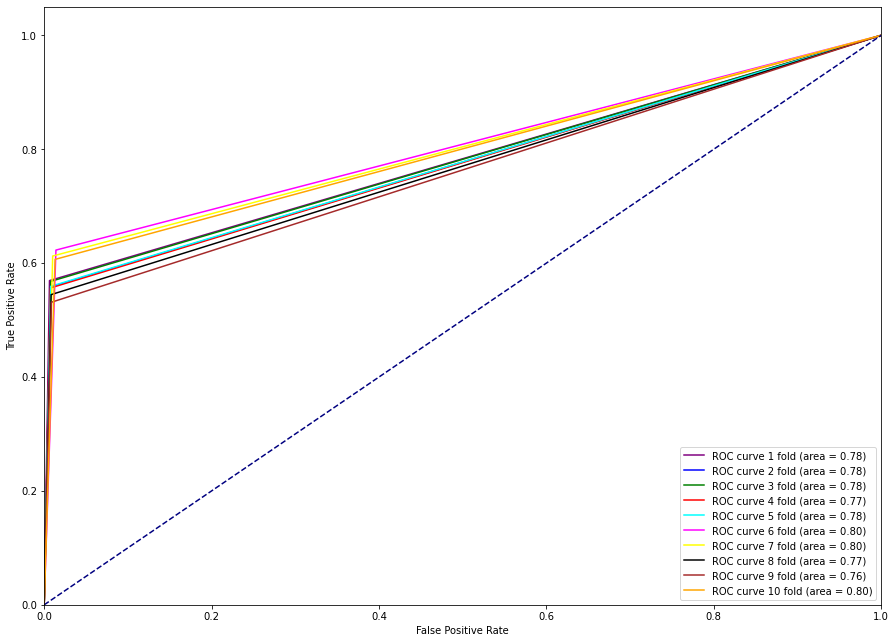

In [40]:
plt.figure(figsize = (15, 11))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'orange', 'purple']

for i in range(10):        
    plt.plot(roc_list[i][0], roc_list[i][1], color=colors[i-1], label=f'ROC curve {i+1} fold (area = %0.2f)' % roc_list[i][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [41]:
for i,roc in enumerate(roc_list):
    print(f'ROC curve {i+1} fold (area = {roc[2]}) ')

ROC curve 1 fold (area = 0.7814894011045657) 
ROC curve 2 fold (area = 0.7752576629626502) 
ROC curve 3 fold (area = 0.7800654043835952) 
ROC curve 4 fold (area = 0.7744996840263056) 
ROC curve 5 fold (area = 0.7757290234756263) 
ROC curve 6 fold (area = 0.8044241779238568) 
ROC curve 7 fold (area = 0.8011425149282054) 
ROC curve 8 fold (area = 0.7682001870472039) 
ROC curve 9 fold (area = 0.7613307572879507) 
ROC curve 10 fold (area = 0.796783258364553) 
